# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir

plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/'

os.system("mkdir -p "+ plotDir)

0

# ALL BKG TAG EFF

In [3]:
tags = []
tags = [
    


        'Data 2016',
        'Data 2017',
        'Data 2018',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

fnames['Data 2016'] = 'V1p17/v5/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_GoodLumi.root'
fnames['Data 2017'] = 'V1p17/v5/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root'
fnames['Data 2018'] = 'V1p17/v5/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018_GoodLumi.root'


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v5/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_GoodLumi.root
Open ready
Data 2016
Tree ready
<TTree b'SusyLLPTree' at 0x7f96090ebd68> OrderedDict([('Data 2016', <TTree b'SusyLLPTree' at 0x7f96090ebd68>)])
[[0.0060166237] [0.60657066 0.55143964 0.5776966] [0.44893625] ... [0.46687952 0.73789394] [0.30604082] [0.017801568]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v5/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root
Open ready
Data 2017
Tree ready
<TTree b'SusyLLPTree' at 0x7f95c7559cc0> OrderedDict([('Data 2016', <TTree b'SusyLLPTree' at 0x7f96090ebd68>), ('Data 2017', <TTree b'SusyLLPTree' at 0x7f95c7559cc0>)])
[[0.3825053 0.8962604] [0.2581324 0.66461104 0.44873026] [0.513396 0.71617186 0.32877555 0.44576126 0.46733537] ... [0.3403

# Tag Eff Measurement Region

In [16]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# mt_cut=100
mt_cut=80

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_rho = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
    rho = v['rho'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    mt = v['MT'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==1)
#     basic_met_str = np.logical_and(basic_met_str, mt<mt_cut)
    basic_met_str = np.logical_and(basic_met_str, mt>mt_cut)
    basic_met_str = np.logical_and(basic_met_str, mt<2*mt_cut)
    
    if veto==1:
#         basic_met_str = np.logical_and(basic_met_str, nmu==0)
#         basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_rho[k] = rho[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_rho[k] = trg_jet_rho[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
(2390101,)
79977
79977
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
(3438214,)
99560
99560
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>
(8328678,)
155630
155630


In [17]:
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/'+'Data/goodlumi_1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/'+'Data/MT100/'   
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/'+'Data/MT80/'   
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/'+'Data/MT80-160/'   
 
print(plotDir)
os.system("mkdir -p "+ plotDir)

/storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/Data/MT80-160/


0

# Tags

In [18]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
[[] [90.3784] [282.51575] ... [133.76453 74.37943 50.051834] [309.26938 110.7613 55.10583 39.818962] [293.25067]]
[[] [] [] ... [] [] []]
[[] [90.3784] [282.51575] ... [133.76453 74.37943 50.051834] [309.26938 110.7613 55.10583 39.818962] [293.25067]]
[0 1 2 3 4 5 6 7 8 9]
[0 1]
[0 1]
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
[[220.49371 194.81148 113.98699 37.796703] [141.73851 75.54172] [164.16562] ... [476.12823] [] [175.46631]]
[[] [] [] ... [] [] []]
[[220.49371 194.81148 113.98699 37.796703] [141.73851 75.54172] [164.16562] ... [476.12823] [] [175.46631]]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1]
[0 1]
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>
[[] [158.56593 60.004375] [188.6643] ... [246.4127] [198.1215 136.6388] [304.43988 87.40086 65.27934]]
[[] [] [] ... [] [] []]
[[] [158.56593 60.004375] [188.6643] ... [246.4127] [198.1215 136.6388] [304.43988 87.40086 65.27934]]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1]


# Tag Eff

In [13]:
from itertools import chain 

wall = {}
wnum = {}

#var
pt_denall = {}
eta_denall = {}
phi_denall = {}
pt_numall = {}
eta_numall = {}
phi_numall = {}

#h1s
pt_den_all = {}
eta_den_all = {}
phi_den_all = {}
pt_num_all = {}
eta_num_all = {}
phi_num_all = {}

#pEffs of h1
pt_pEff = {}
eta_pEff = {}
phi_pEff = {}

#h2s
pt_eta_den_all = {}
pt_phi_den_all = {}
pt_eta_num_all = {}
pt_phi_num_all = {}

#pEffs of h2
pt_eta_pEff = {}
pt_phi_pEff = {}

for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    eta_denall[k] = np.array(trg_jet_eta[k].flatten())
    phi_denall[k] = np.array(trg_jet_phi[k].flatten())
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(eta_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    eta_numall[k] =  np.array(tag_jet_eta[k].flatten())
    phi_numall[k] =  np.array(tag_jet_phi[k].flatten())
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
#     print(len(trg_jet_w[k]))
#     print(len(tag_jet_pt[k]))
    
    print(len(pt_numall[k]))
    print(len(eta_numall[k]))
#     print(max(eta_numall[k]))
#     print(min(eta_numall[k]))
#     print(eta_numall[k])
#     print(pt_numall[k])
    print(len(wnum[k]))
    
    #pt histogram
#     pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wall[k])
#     pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[20,-0,1000], weights=wnum[k])
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])

    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
#     x=array('d', [10*ix for ix in range(100)])
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100])
#     x=array('d', [1,100,200,300,400,500,600,700,800,900])
    
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    print(pt_den_all[k].GetNbinsX())

    
#     #eta histogram
#     eta_den_all[k] = create_TH1D( eta_denall[k], axis_title=['jetEta ', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wall[k])
#     eta_num_all[k] = create_TH1D( eta_numall[k], axis_title=['jetEta', 'fraction of events'], name="", binning=[20,-1.5,1.5], weights=wnum[k])
  
#     phi_den_all[k] = create_TH1D( phi_denall[k], axis_title=['jetPhi ', 'fraction of events'], name="", binning=[20,-3.15,3.15], weights=wall[k])
#     phi_num_all[k] = create_TH1D( phi_numall[k], axis_title=['jetPhi', 'fraction of events'], name="", binning=[20,-3.15,3.15], weights=wnum[k])
  
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
#     eta_pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#     phi_pEff[k] = rt.TEfficiency(phi_num_all[k], phi_den_all[k])
#     print(pt_pEff[k].GetPassedHistogram().GetNbinsX())
    
#     #2d ones
#     pt_eta_den_all[k] = create_TH2D(np.vstack((pt_denall[k], eta_denall[k])).T, name='', title=None, binning=[20,0,1000,20,-1.5,1.5], weights=wall[k], axis_title = ['jetPt [GeV]','jetEta', ''])
#     pt_eta_num_all[k] = create_TH2D(np.vstack((pt_numall[k], eta_numall[k])).T, name='', title=None, binning=[20,0,1000,20,-1.5,1.5], weights=wnum[k], axis_title = ['jetPt [GeV]','jetEta', ''])

#     pt_phi_den_all[k] = create_TH2D(np.vstack((pt_denall[k], phi_denall[k])).T, name='', title=None, binning=[20,0,1000,20,-3.15,3.15], weights=wall[k], axis_title = ['jetPt [GeV]','jetPhi', ''])
#     pt_phi_num_all[k] = create_TH2D(np.vstack((pt_numall[k], phi_numall[k])).T, name='', title=None, binning=[20,0,1000,20,-3.15,3.15], weights=wnum[k], axis_title = ['jetPt [GeV]','jetPhi', ''])
    
#     #2d efficiency
#     pt_eta_pEff[k] = rt.TEfficiency(pt_eta_num_all[k], pt_eta_den_all[k])
#     pt_phi_pEff[k] = rt.TEfficiency(pt_phi_num_all[k], pt_phi_den_all[k])  
    

Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
506570
506570
506570
445
445
445
100
19
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
547263
547263
547263
342
342
342
100
19
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>
982160
982160
982160
335
335
335
100
19


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent


In [14]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.002],
#         ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.01],
#         ['jetEta', eta_pEff, 'eta', -0.0002, 0.01],
#         ['jetPhi', phi_pEff, 'phi', -0.0002, 0.01],
        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/Data/MT80/tag_eff_jet_pt_rebin.png has been created


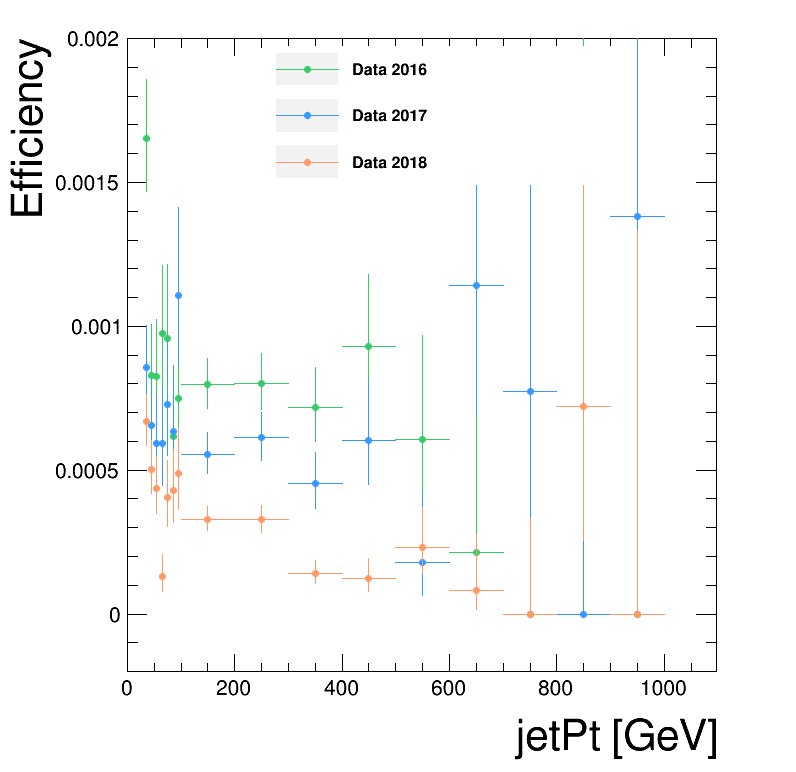

In [15]:

   

color_list = [845,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


# Tag Eff 80-160

In [19]:
from itertools import chain 

# wall = {}
# wnum = {}

# #var
# pt_denall = {}
# eta_denall = {}
# phi_denall = {}
# pt_numall = {}
# eta_numall = {}
# phi_numall = {}

# #h1s
# pt_den_all = {}
# eta_den_all = {}
# phi_den_all = {}
# pt_num_all = {}
# eta_num_all = {}
# phi_num_all = {}

# #pEffs of h1
# pt_pEff = {}
# eta_pEff = {}
# phi_pEff = {}

# #h2s
# pt_eta_den_all = {}
# pt_phi_den_all = {}
# pt_eta_num_all = {}
# pt_phi_num_all = {}

# #pEffs of h2
# pt_eta_pEff = {}
# pt_phi_pEff = {}

for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
  
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
   
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
    
    print(len(pt_numall[k]))

    print(len(wnum[k]))
    
    #pt histogram
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])

    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
 
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    print(pt_den_all[k].GetNbinsX())

    
 
    #efficiency
    pt_pEff[k+'80-160'] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
 

Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
138931
138931
136
136
100
19
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
167243
167243
106
106
100
19
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>
240781
240781
82
82
100
19


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent


In [20]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.002],
        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/Data/MT80-160/tag_eff_jet_pt_rebin.png has been created


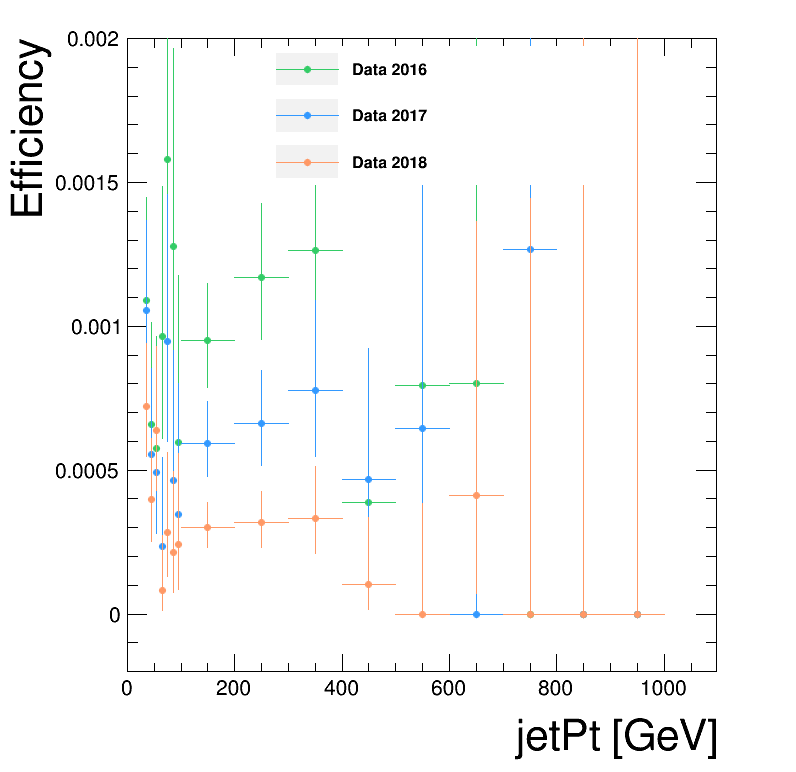

In [21]:

   

color_list = [845,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k+'80-160']
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


In [23]:
for tag in tags:
    print(tag)
    print(tag.replace(' ','_'))
    

Data 2016
Data_2016
Data 2017
Data_2017
Data 2018
Data_2018


var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>
Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>
Data 2016 <TTree b'SusyLLPTree' at 0x7f96090ebd68>
Data 2017 <TTree b'SusyLLPTree' at 0x7f95c7559cc0>
Data 2018 <TTree b'SusyLLPTree' at 0x7f95c4b6bef0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/Data/MT80-160/tag_eff_jet_pt_rebin_Data_2016.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/Data/MT80-160/tag_eff_jet_pt_rebin_Data_2017.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/Data/MT80-160/tag_eff_jet_pt_rebin_Data_2018.png has been created


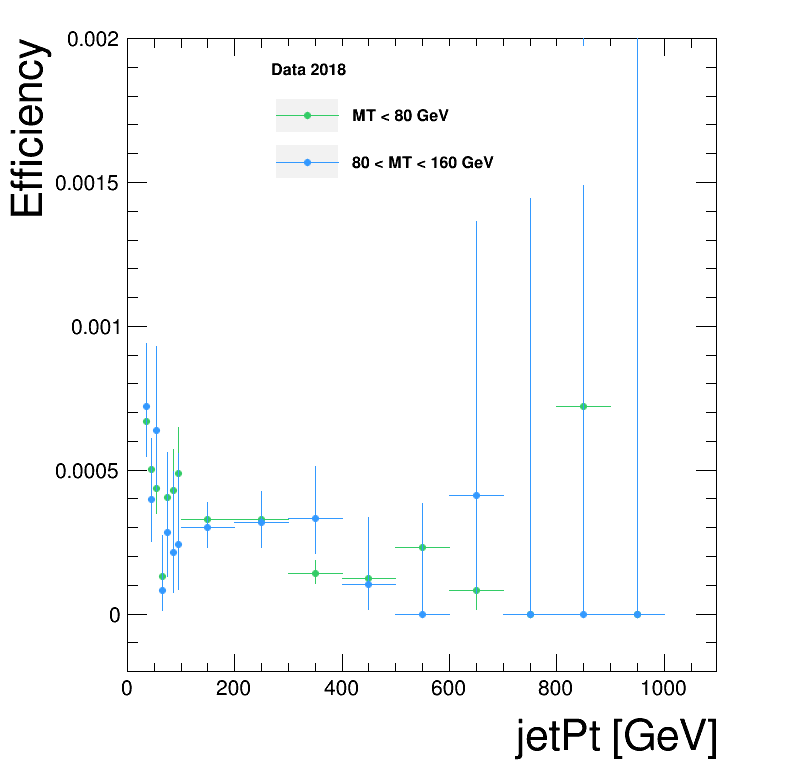

In [25]:

   

color_list = [845,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
    for tag in tags:
        year = tag.replace(' ','_')
        outf = 'tag_eff_jet_'+var[2]+'_rebin_'+year+'.png'
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.33,0.76,0.78,0.94)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        i = 0
        for k,v in tree.items(): 
            print(k,v)


            if tag in k:
                pEff[k] = var[1][k]
                pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

                pEff[k].SetLineColor(color_list[i])
                pEff[k].SetMarkerColor(color_list[i])
                pEff[k].SetMarkerSize(0.8)
                pEff[k].SetMarkerStyle(20)
                
                pEff[k+'80-160'] = var[1][k+'80-160']
                pEff[k+'80-160'].SetLineColor(color_list[i+1])
                pEff[k+'80-160'].SetMarkerColor(color_list[i+1])
                pEff[k+'80-160'].SetMarkerSize(0.8)
                pEff[k+'80-160'].SetMarkerStyle(20)

                pEff[k].Draw("apez")
                pEff[k+'80-160'].Draw("pezsame")

                rt.gPad.Update()        
                pEff[k].GetPaintedGraph().SetMarkerStyle(8)
                pEff[k].GetPaintedGraph().SetMarkerSize(20)        
                pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
                pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
                pEff[k].GetPaintedGraph().SetMinimum(var[3])
                pEff[k].GetPaintedGraph().SetMaximum(var[4])
                pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
                pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)

                pEff[k+'80-160'].GetPaintedGraph().SetMarkerStyle(8)
                pEff[k+'80-160'].GetPaintedGraph().SetMarkerSize(20)        
                pEff[k+'80-160'].GetPaintedGraph().SetLineColor(color_list[i+1])        
                pEff[k+'80-160'].GetPaintedGraph().SetMarkerColor(color_list[i+1])        
                pEff[k+'80-160'].GetPaintedGraph().SetMinimum(var[3])
                pEff[k+'80-160'].GetPaintedGraph().SetMaximum(var[4])
                pEff[k+'80-160'].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
                pEff[k+'80-160'].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


                i += 1



                leg.SetHeader(k)
                leg.AddEntry(pEff[k], 'MT < 80 GeV')
                leg.AddEntry(pEff[k+'80-160'],'80 < MT < 160 GeV')

        leg.Draw()

        # c.SetLogy()
        c.SetRightMargin(0.1)
        c.Update()
        c.Draw()
        c.SaveAs(plotDir+outf)


# Tag Eff vs Rho

In [12]:
from itertools import chain 

wall = {}
wnum = {}

#var
rho_denall = {}
rho_numall = {}

#h1s
rho_den_all = {}
rho_num_all = {}

#pEffs of h1
rho_pEff = {}
 

for k,v in tree.items():
    print(k,v)
    
    # denominator
    rho_denall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_rho[k],trg_jet_pt[k])]
    rho_denall[k] = list(chain.from_iterable(rho_denall[k])) 
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(rho_denall[k]))
    print(len(wall[k]))
    
    
    #numerator
    rho_numall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_rho[k],tag_jet_pt[k])]
    rho_numall[k] = list(chain.from_iterable(rho_numall[k])) 
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
    print(len(rho_numall[k]))
    print(len(wnum[k]))
    
    #h1 histogram
    rho_den_all[k] = create_TH1D( rho_denall[k], axis_title=['rho', 'fraction of events'], name="", binning=[100,-0,100], weights=wall[k])
    rho_num_all[k] = create_TH1D( rho_numall[k], axis_title=['rho', 'fraction of events'], name="", binning=[100,-0,100], weights=wnum[k])

    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
#     x=array('d', [10*ix for ix in range(100)])
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
#     x=array('d', [1,10,20,30,40,50,60,70,80,90,100])
#     x=array('d', [1,100,200,300,400,500,600,700,800,900])
    
#     pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
#     pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
#     print(pt_den_all[k].GetNbinsX())

    
 
    #efficiency
    rho_pEff[k] = rt.TEfficiency(rho_num_all[k], rho_den_all[k])
 

Data 2016 <TTree b'SusyLLPTree' at 0x7f3424711c50>
607684
607684
541
541
19
Data 2017 <TTree b'SusyLLPTree' at 0x7f33e2b7bcf8>
660804
660804
413
413
19
Data 2018 <TTree b'SusyLLPTree' at 0x7f33e0193240>
1142619
1142619
392
392
19


In [17]:
variables = [
    
        ['rho', rho_pEff, 'rho', -0.0002, 0.005],
        
]

var/x_axis rho name rho range -0.0002 0.005
Data 2016 <TTree b'SusyLLPTree' at 0x7f3424711c50>
Data 2017 <TTree b'SusyLLPTree' at 0x7f33e2b7bcf8>
Data 2018 <TTree b'SusyLLPTree' at 0x7f33e0193240>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200616/Data/goodlumi_1lep_eb_t-1_phoef_0p8_muef_0p6_eleef_0p6/tag_eff_jet_rho.png has been created


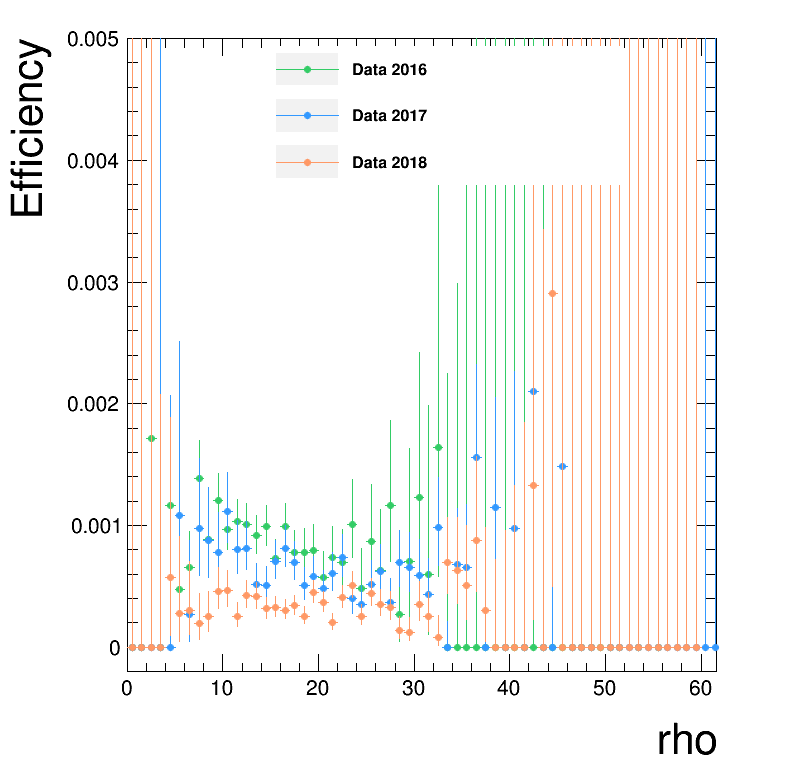

In [18]:

   

color_list = [845,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
    outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)
